In [1]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

# To import 'katakana' from relative path
sys.path.append(os.path.abspath(os.path.join('..')))
from katakana import encoding

INPUT_LENGTH = 20
OUTPUT_LENGTH = 20


Using TensorFlow backend.


# Data pre-processing

In [3]:
with open('../data/stemmer_dataset_many_to_many.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

data_input=[]
data_output=[]
    
num_samples=51400    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    #if(len(input_text)>20 and len(target_text)>20):
     #   print(input_text+" "+target_text)
    data_input.append(input_text)
    data_output.append(target_text)
    
print(data_input[1],data_output[1])    

জলছবিতে। বিনয়-বাদল-দীনেশ বাহিনীর জলছবিতে। বিনয়-বাদল-দীনেশ বাহিনীর


In [4]:
#data = pd.read_csv('../data/joined_titles.csv', header=None)
#data = data.sample(frac=1, random_state=0)

########################data_input = [s.decode('utf-8').lower() for s in data[0]]
########################data_output = [s.decode('utf-8') for s in data[1]]

#data_input = [s.lower() for s in data[0]]
#data_output = [s for s in data[1]]

#print(data_input[0], data_output[0])
#print(data_input[5], data_output[5])


data_size = len(data_input)

# We will use the first 0-60th %-tile (60%) of data for the training
training_input  = data_input[int(data_size*0/100):int(data_size*60/100)]
training_output = data_output[int(data_size*0/100):int(data_size*60/100)]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_input = data_input[int(data_size*60/100):int(data_size*70/100)]
validation_output = data_output[int(data_size*60/100):int(data_size*70/100)]

print('training size', len(training_input))
print('validation size', len(validation_input))

training size 30839
validation size 5140


### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [5]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('English character dict size:', input_dict_size)
print('Katakana character dict size:', output_dict_size)

encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

English character dict size: 101
Katakana character dict size: 100
encoded_training_input (30839, 20)
encoded_training_output (30839, 20)
encoded_validation_input (5140, 20)
encoded_validation_output (5140, 20)


# Sequence-to-Sequence in Keras

In [6]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

### Encoder / Decoder

In [7]:
from keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, 64, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(64, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, 64, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(64, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder Tensor("lstm_1/transpose_2:0", shape=(?, 20, 64), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(?, 64), dtype=float32)
decoder Tensor("lstm_2/transpose_2:0", shape=(?, 20, 64), dtype=float32)


### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [8]:
from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)


attention Tensor("attention/truediv:0", shape=(?, 20, 20), dtype=float32)
context Tensor("dot_2/MatMul:0", shape=(?, 20, 64), dtype=float32)
decoder_combined_context Tensor("concatenate_1/concat:0", shape=(?, 20, 128), dtype=float32)
output Tensor("time_distributed_2/Reshape_1:0", shape=(?, 20, 100), dtype=float32)


In [9]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

## Training the model

In [10]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [11]:
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    history=model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=30) #epochs=30)
                      
history=model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=5)

model.save('model.h5')

Train on 30839 samples, validate on 5140 samples
Epoch 1/30
 - 78s - loss: 0.0410 - acc: 0.9902 - val_loss: 0.0364 - val_acc: 0.9903
Epoch 2/30
 - 45s - loss: 0.0331 - acc: 0.9911 - val_loss: 0.0289 - val_acc: 0.9924
Epoch 3/30
 - 45s - loss: 0.0152 - acc: 0.9958 - val_loss: 0.0072 - val_acc: 0.9983
Epoch 4/30
 - 46s - loss: 0.0041 - acc: 0.9990 - val_loss: 0.0044 - val_acc: 0.9989
Epoch 5/30
 - 45s - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0038 - val_acc: 0.9990
Epoch 6/30
 - 45s - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0036 - val_acc: 0.9991
Epoch 7/30
 - 45s - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0034 - val_acc: 0.9991
Epoch 8/30
 - 45s - loss: 0.0021 - acc: 0.9994 - val_loss: 0.0033 - val_acc: 0.9991
Epoch 9/30
 - 45s - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0032 - val_acc: 0.9991
Epoch 10/30
 - 45s - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0032 - val_acc: 0.9991
Epoch 11/30
 - 44s - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0032 - val_acc: 0.9991
Epoch 12/30
 - 45s - loss

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


### Testing the model


In [31]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
    return text

def to_katakana(text):
    decoder_output = generate(text)
    return decode(output_decoding, decoder_output[0])


common_american_names = ['James', 'John', 'Robert', 'Mary', 'Patricia', 'Linda']

common_american_names=['Unschooling',
'Lovosice',
'Milch',
'Juva',
'Brembilla',
'Sa Pa',
'Brumano',
'Brusaporto',
'Deventer',
'Enschede']

common_american_names=['এই বটের আশ্রয়ে',
'ঐ বটের ছায়ায়',
'বটে! বটে! বটে!',
'বিচিত্র বটে! লাল',
'১২ই মে ২০২৫',
'আজ মে মাস',
'হাসিতে মেতে উঠল' ]

for name in common_american_names:
    print(name, to_katakana(name))

এই বটের আশ্রয়ে এই বট আশ্রয়ে
ঐ বটের ছায়ায় ঐো বের ছায়ায়
বটে! বটে! বটে! বটে! বটে বটে!
বিচিত্র বটে! লাল বিচিত্র বটে লাল
১২ই মে ২০২৫ ১২ই মে ২০২
আজ মে মাস আজ মে মাস
হাসিতে মেতে উঠল হাসিতে মেতে উঠল


In [27]:
#print(to_katakana('সাদা লাল নীল'))
#print(to_katakana('Peter Parker'))
#print(to_katakana('Jonny Snow'))

with open('../data/stemmer_dataset_many_to_many.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[30000: 40005]:
    test_input_text, test_target_text = line.split('\t')
    print(test_input_text+"------"+to_katakana(test_input_text))

তলোয়ারে করদাতাকেই পুত্রশোকে------তলোয়ারে করদাতা পুলি
করদাতাকেই পুত্রশোকে হালখাতায়------করদাতাকেই পুত্রশোক 
পুত্রশোকে হালখাতায় খননক্ষেত্রের------পুত্রশোকে হালখাতা খ
হালখাতায় খননক্ষেত্রের মন্দিরগুলোর------হালখাতায় খননক্ষেত্র
খননক্ষেত্রের মন্দিরগুলোর ফটোশপে------খননক্ষেত্রের মন্দির
মন্দিরগুলোর ফটোশপে ওরাকলের------মন্দিরগুলোর ফটোশপ ও
ফটোশপে ওরাকলের বকুলতলার------ফটোশপে ওরাকল বকুলতা
ওরাকলের বকুলতলার এসির------ওরাকলের বকুলতলা এসি
বকুলতলার এসির কেলেঙ্কারিতেই------বকুলতলার এসি কেলেঙ্
এসির কেলেঙ্কারিতেই মেষের------এসির কেলেঙ্কারিত মা
কেলেঙ্কারিতেই মেষের এসিও------কেলেঙ্কারিতেই মেষ ম
মেষের এসিও ডাইক্লোফেনাকও------মেষের এসি ডাইক্লোফে
এসিও ডাইক্লোফেনাকও ফ্লোরে------এসিও ডাইক্লোফেনা ফা
ডাইক্লোফেনাকও ফ্লোরে তরাইর------ডাইক্লোফেনাকও ফ্লোর
ফ্লোরে তরাইর স্বীকৃতিটা------ফ্লোরে তরাই স্বীকৃত
তরাইর স্বীকৃতিটা চেহারাটিও------তরাইর স্বীকৃতি চেহে
স্বীকৃতিটা চেহারাটিও অসম্মানের------স্বীকৃতিটা চেহারা স
চেহারাটিও অসম্মানের ব্রাহ্মণীকুন্ডায়------চেহারাটিও অসম্মান স
অসম্মানের ব্রাহ্মণীকুন্ডায় মহাসচিবের------অসম্ম

অলিম্পিয়াডগুলোতে বাক্সগুলোতে শায়লার------অলিম্পিয়াডগুলোতে বা
বাক্সগুলোতে শায়লার বাহুবলের------বাক্সগুলোতে শায়লা ব
শায়লার বাহুবলের বেদিতেই------শায়লার বাহুবল বেদির
বাহুবলের বেদিতেই রেডিতে------বাহুবলের বেদিত রেডি
বেদিতেই রেডিতে চেয়ারই------বেদিতেই রেডি চেয়ারে
রেডিতে চেয়ারই অসহযোগিতার------রেডিতে চেয়ার অসহযোগ
চেয়ারই অসহযোগিতার চেয়ারও------চেয়ারই অসহযোগিতা চে
অসহযোগিতার চেয়ারও জারাগোজাকে------অসহযোগিতার চেয়ার জা
চেয়ারও জারাগোজাকে ফর্মটি------চেয়ারও জারাগোজা ফর্
জারাগোজাকে ফর্মটি ফর্মটা------জারাগোজাকে ফর্ম ফর্
ফর্মটি ফর্মটা মানবাধিকারসমূহের------ফর্মটি ফর্ম মানবাধি
ফর্মটা মানবাধিকারসমূহের নাভানার------ফর্মটা মানবাধিকার ম
মানবাধিকারসমূহের নাভানার জেনির------মানবাধিকারসমূহের না
নাভানার জেনির পুরুষে------নাভানার জেনি পুরুষে
জেনির পুরুষে ডানহাতটা------জেনির পুরুষ ডানহাতট
পুরুষে ডানহাতটা মনিরুলকে------পুরুষে ডানহাত মনির
ডানহাতটা মনিরুলকে ওয়ারেছের------ডানহাতটা মনিরুল ওয়া
মনিরুলকে ওয়ারেছের গমেজের------মনিরুলকে ওয়ারেছ গম্
ওয়ারেছের গমেজের মহাসচিবকে------ওয়ারেছের গমেজ মহাস্
গমেজের মহাসচিবকে এলোচুল

মানুষগুলোর ফর্মকে হাঁড়িতে------মানুষগুলোর ফর্ম হার
ফর্মকে হাঁড়িতে প্রতাপাদিত্যকে------ফর্মকে হাঁড়ি প্রতার
হাঁড়িতে প্রতাপাদিত্যকে আত্মহত্যাগুলোর------হাঁড়িতে প্রতাপাদিত্
প্রতাপাদিত্যকে আত্মহত্যাগুলোর সম্মানীয়------প্রতাপাদিত্যকে আত্ম
আত্মহত্যাগুলোর সম্মানীয় মানুষগুলোই------আত্মহত্যাগুলোর সম্ম
সম্মানীয় মানুষগুলোই স্ত্রীদেরও------সম্মানীয় মানুষ স্যা
মানুষগুলোই স্ত্রীদেরও বেন্টিলই------মানুষগুলোই স্ত্রী ব
স্ত্রীদেরও বেন্টিলই স্ত্রীদেরই------স্ত্রীদেরও বেন্টিল 
বেন্টিলই স্ত্রীদেরই সম্মানীর------বেন্টিলই স্ত্রী মাল
স্ত্রীদেরই সম্মানীর বিলাইছড়িতে------স্ত্রীদেরই সম্মানী 
সম্মানীর বিলাইছড়িতে দলিতদের------সম্মানীর বিলাইছড়ি স
বিলাইছড়িতে দলিতদের পুষ্পিতার------বিলাইছড়িতে দলিত প্র
দলিতদের পুষ্পিতার কলেজসমূহের------দলিতদের পুষ্পিতা কল
পুষ্পিতার কলেজসমূহের সম্মানীও------পুষ্পিতার কলেজ মামা
কলেজসমূহের সম্মানীও থান্ডারবার্ডের------কলেজসমূহের সম্মানী 
সম্মানীও থান্ডারবার্ডের অধিনায়কত্বটাকে------সম্মানীও থান্ডারবার
থান্ডারবার্ডের অধিনায়কত্বটাকে বিএমপিআইএর------থান্ডারবার্ডের অধিন
অধিনায়কত্বটাকে বিএমপিআই

ব্যবধানটা ব্যবধানটি সংসদকক্ষে------ব্যবধানটা ব্যবধান স
ব্যবধানটি সংসদকক্ষে প্রকল্পগুলোয়------ব্যবধানটি সংসদকক্ষ 
সংসদকক্ষে প্রকল্পগুলোয় খাদ্যনিরাপত্তাহীনতার------সংসদকক্ষে প্রকল্প ব
প্রকল্পগুলোয় খাদ্যনিরাপত্তাহীনতার পাদনের------প্রকল্পগুলোয় খাদ্যন
খাদ্যনিরাপত্তাহীনতার পাদনের এসইউসিআইয়ের------খাদ্যনিরাপত্তাহীনতা
পাদনের এসইউসিআইয়ের আজহারুলের------পাদনের এসইউসিআই আইন
এসইউসিআইয়ের আজহারুলের অতসীদের------এসইউসিআইয়ের আজহারুল
আজহারুলের অতসীদের বালাকের------আজহারুলের অতসী বার্
অতসীদের বালাকের কয়েদিরা------অতসীদের বালাক কয়েদে
বালাকের কয়েদিরা আমলকে------বালাকের কয়েদি আমলকে
কয়েদিরা আমলকে চারপাশে------কয়েদিরা আমল চারপাশি
আমলকে চারপাশে জেসমিনকে------আমলকে চারপাশ জেসমিন
চারপাশে জেসমিনকে শাসকদেরও------চারপাশে জেসমিন শাস্
জেসমিনকে শাসকদেরও চিন্তারামছড়ার------জেসমিনকে শাসক চিক্র
শাসকদেরও চিন্তারামছড়ার টেস্টিংয়ে------শাসকদেরও চিন্তারামছ
চিন্তারামছড়ার টেস্টিংয়ে সৃষ্টিশীলতায়------চিন্তারামছড়ার টেস্ট
টেস্টিংয়ে সৃষ্টিশীলতায় বাইরেই------টেস্টিংয়ে সৃষ্টিশীল
সৃষ্টিশীলতায় বাইরেই ব্র্যান্ডগুলোই------সৃষ্টিশীলতায় 

সাংগ্রুলার পাউডারও নাশকতায়------সাংগ্রুলার পাউডার ন
পাউডারও নাশকতায় রাজনীতিকদের------পাউডারও নাশকতা রাজন
নাশকতায় রাজনীতিকদের তরলের------নাশকতায় রাজনীতিক স্
রাজনীতিকদের তরলের নাশকতার------রাজনীতিকদের তরল নার
তরলের নাশকতার নিশিকে------তরলের নাশকতা নিশিকে
নাশকতার নিশিকে ডেলমারের------নাশকতার নিশি ডেলমার
নিশিকে ডেলমারের সংয়ের------নিশিকে ডেলমার সংয়ে
ডেলমারের সংয়ের ঋণসহায়তার------ডেলমারের সং ঋণসহারে
সংয়ের ঋণসহায়তার কোডাককে------সংয়ের ঋণসহায়তা কোডা
ঋণসহায়তার কোডাককে সড়কপথে------ঋণসহায়তার কোডাক সড়া
কোডাককে সড়কপথে জিম্বাবুয়েরও------কোডাককে সড়কপথ জিম্ব
সড়কপথে জিম্বাবুয়েরও দেয়ে------সড়কপথে জিম্বাবুয়ে ম
জিম্বাবুয়েরও দেয়ে ঋণসহায়তায়------জিম্বাবুয়েরও দেয় ঋণ
দেয়ে ঋণসহায়তায় জ্ঞানগুলো------দেয়ে ঋণসহায়তা জ্ঞান
ঋণসহায়তায় জ্ঞানগুলো আজকের------ঋণসহায়তায় জ্ঞান স্য
জ্ঞানগুলো আজকের ম্যান্ডেলার------জ্ঞানগুলো আজ ম্যানে
আজকের ম্যান্ডেলার অর্চনার------আজকের ম্যান্ডেলা অর
ম্যান্ডেলার অর্চনার বাফুফের------ম্যান্ডেলার অর্চনা 
অর্চনার বাফুফের বিন্দুটি------অর্চনার বাফুফে বিন্
বাফুফের বিন্দুটি স্থাপনাশিল্পে------বাফ

ছড়াগুলো হিমাগারগুলোতে বালাককে------ছড়াগুলো হিমাগার স্য
হিমাগারগুলোতে বালাককে আইডিএলসিতে------হিমাগারগুলোতে বালা 
বালাককে আইডিএলসিতে ভগবানের------বালাককে আইডিএলসি ভা
আইডিএলসিতে ভগবানের ইয়েদ্দুরাপ্পার------আইডিএলসিতে ভগবান ইন
ভগবানের ইয়েদ্দুরাপ্পার আফরোজের------ভগবানের ইয়েদ্দুরাপ্
ইয়েদ্দুরাপ্পার আফরোজের আসাদুজ্জামানও------ইয়েদ্দুরাপ্পার আফরো
আফরোজের আসাদুজ্জামানও লুত্ফরকে------আফরোজের আসাদুজ্জামা
আসাদুজ্জামানও লুত্ফরকে সমর্থকগোষ্ঠীর------আসাদুজ্জামানও লুত্ফ
লুত্ফরকে সমর্থকগোষ্ঠীর ছাওয়াটার------লুত্ফরকে সমর্থকগোষ্
সমর্থকগোষ্ঠীর ছাওয়াটার ছালামকে------সমর্থকগোষ্ঠীর ছাওয়া
ছাওয়াটার ছালামকে ধনের------ছাওয়াটার ছালাম ধনে
ছালামকে ধনের পরপরই------ছালামকে ধন পরপরই
ধনের পরপরই এফএফসির------ধনের পরপর এফএফসির
পরপরই এফএফসির ব্যায়ামও------পরপরই এফএফসি ব্যায়া
এফএফসির ব্যায়ামও রামধানায়------এফএফসির ব্যায়াম রাম
ব্যায়ামও রামধানায় ভোগব্যয়ে------ব্যায়ামও রামধানা ভো
রামধানায় ভোগব্যয়ে বরখাস্তের------রামধানায় ভোগব্যয় বর
ভোগব্যয়ে বরখাস্তের হাসানকে------ভোগব্যয়ে বরখাস্ত হা
বরখাস্তের হাসানকে সুদেপকে------বরখাস্তের হ

রেফারিকেই আফরোজকে আবৃত্তিকারেরা------রেফারিকেই আফরোজ আবা
আফরোজকে আবৃত্তিকারেরা এবিজিএলের------আফরোজকে আবৃত্তিকার 
আবৃত্তিকারেরা এবিজিএলের হরভজনকে------আবৃত্তিকারেরা এবিজি
এবিজিএলের হরভজনকে অভিষেকই------এবিজিএলের হরভজন অভা
হরভজনকে অভিষেকই লিবীয়রা------হরভজনকে অভিষেক লিবী
অভিষেকই লিবীয়রা শীর্ষস্থানেও------অভিষেকই লিবীয় শীর্ত
লিবীয়রা শীর্ষস্থানেও ভরাতে------লিবীয়রা শীর্ষস্থান 
শীর্ষস্থানেও ভরাতে দশানীর------শীর্ষস্থানেও ভরা দে
ভরাতে দশানীর শিমুলগাছের------ভরাতে দশানী শিমুলগা
দশানীর শিমুলগাছের রেসিংয়ের------দশানীর শিমুলগাছ রেন
শিমুলগাছের রেসিংয়ের বাণিজ্যটা------শিমুলগাছের রেসিং মা
রেসিংয়ের বাণিজ্যটা কামারুজ্জামানও------রেসিংয়ের বাণিজ্য কা
বাণিজ্যটা কামারুজ্জামানও প্রযোজনাটির------বাণিজ্যটা কামারুজ্জ
কামারুজ্জামানও প্রযোজনাটির বেকহামও------কামারুজ্জামানও প্রয
প্রযোজনাটির বেকহামও এফপিএসএমপিকে------প্রযোজনাটির বেকহাম 
বেকহামও এফপিএসএমপিকে অডিটের------বেকহামও এফপিএসএমপি 
এফপিএসএমপিকে অডিটের চাপটাকে------এফপিএসএমপিকে অডিট ম
অডিটের চাপটাকে মাহদীর------অডিটের চাপটা মাহদীর
চাপটাকে মাহদীর সময়সূচিতে

সুদানে এনআইএর টাউনের------সুদানে এনআইএ টাউনের
এনআইএর টাউনের বনভূমির------এনআইএর টাউন বনভূমিক
টাউনের বনভূমির প্রচারপত্রে------টাউনের বনভূমি প্রচা
বনভূমির প্রচারপত্রে জবাইখানা------বনভূমির প্রচারপত্র 
প্রচারপত্রে জবাইখানা চলতেই------প্রচারপত্রে জবাইখান
জবাইখানা চলতেই জয়পুরেরই------জবাইখানা চলতে জয়পুর
চলতেই জয়পুরেরই কন্ট্রোলকে------চলতেই জয়পুর কন্ট্রা
জয়পুরেরই কন্ট্রোলকে কাগজেরও------জয়পুরেরই কন্ট্রোল স
কন্ট্রোলকে কাগজেরও অপ্রাপ্তবয়স্কদের------কন্ট্রোলকে কাগজ অন্
কাগজেরও অপ্রাপ্তবয়স্কদের ঢাকাকে------কাগজেরও অপ্রাপ্তবয়স
অপ্রাপ্তবয়স্কদের ঢাকাকে সুস্থে------অপ্রাপ্তবয়স্কদের ঢা
ঢাকাকে সুস্থে জেরায়------ঢাকাকে সুস্থ জেরায়
সুস্থে জেরায় সুপারকে------সুস্থে জেরা সুপারকে
জেরায় সুপারকে জালালিকে------জেরায় সুপার জালালিক
সুপারকে জালালিকে চৌয়ের------সুপারকে জালালি চৌয়া
জালালিকে চৌয়ের উক্তিকে------জালালিকে চৌয় উক্তিক
চৌয়ের উক্তিকে জেরেই------চৌয়ের উক্তি জেরেই
উক্তিকে জেরেই ধুলার------উক্তিকে জেরে ধুলার
জেরেই ধুলার এরিকসনের------জেরেই ধুলা এরিকসনের
ধুলার এরিকসনের খসরুজ্জামানের------ধুলার এরিকসন খসরুজ
এর

প্রাইসেরও জনসনের শোয়েনস্টাইগাররাও------প্রাইসেরও জনসন শোয়া
জনসনের শোয়েনস্টাইগাররাও যুবদলে------জনসনের শোয়েনস্টাইগা
শোয়েনস্টাইগাররাও যুবদলে কবিরাজদের------শোয়েনস্টাইগাররাও যু
যুবদলে কবিরাজদের জেনিটরকে------যুবদলে কবিরাজ জেনি
কবিরাজদের জেনিটরকে আলোচনাটি------কবিরাজদের জেনিট আম্
জেনিটরকে আলোচনাটি বার্ধক্যেই------জেনিটরকে আলোচনা বার
আলোচনাটি বার্ধক্যেই আলোচনাটা------আলোচনাটি বার্ধক্য স
বার্ধক্যেই আলোচনাটা দারোয়ানেরা------বার্ধক্যেই আলোচনা স
আলোচনাটা দারোয়ানেরা গকুলনগরের------আলোচনাটা দারোয়ান স্
দারোয়ানেরা গকুলনগরের জহুরুলরা------দারোয়ানেরা গকুলনগর 
গকুলনগরের জহুরুলরা কষার------গকুলনগরের জহুরুল ক্
জহুরুলরা কষার আইপডের------জহুরুলরা কষা আইপডের
কষার আইপডের প্রস্রাবে------কষার আইপড প্রস্রাবি
আইপডের প্রস্রাবে আফ্রিকার------আইপডের প্রস্রাব আফ্
প্রস্রাবে আফ্রিকার ছিদ্রের------প্রস্রাবে আফ্রিকা ছ
আফ্রিকার ছিদ্রের সূচনার------আফ্রিকার ছিদ্র সূচি
ছিদ্রের সূচনার প্রণেতারা------ছিদ্রের সূচনা প্রণে
সূচনার প্রণেতারা মিয়ানমারকেও------সূচনার প্রণেতা মিয়া
প্রণেতারা মিয়ানমারকেও সমর্থকই------প্রণেতারা মিয়ানম

জাদিকে ত্বাবাংয়ের ইসিএফের------জাদিকে ত্বাবাং ইসনা
ত্বাবাংয়ের ইসিএফের জিম্বাবুয়েতেই------ত্বাবাংয়ের ইসিএফ জা
ইসিএফের জিম্বাবুয়েতেই প্রোডাক্টকে------ইসিএফের জিম্বাবুয়ে 
জিম্বাবুয়েতেই প্রোডাক্টকে ভাগ্যকুলে------জিম্বাবুয়েতেই প্রোড
প্রোডাক্টকে ভাগ্যকুলে তালাগুলোই------প্রোডাক্টকে ভাগ্যকু
ভাগ্যকুলে তালাগুলোই আর্সেনালকে------ভাগ্যকুলে তালা স্যা
তালাগুলোই আর্সেনালকে বাংলামোটরেরই------তালাগুলোই আর্সেনাল 
আর্সেনালকে বাংলামোটরেরই বস্তিগুলো------আর্সেনালকে বাংলামোট
বাংলামোটরেরই বস্তিগুলো ব্ল্যাটারকে------বাংলামোটরেরই বস্তিগ
বস্তিগুলো ব্ল্যাটারকে রেঞ্জে------বস্তিগুলো ব্ল্যাটার
ব্ল্যাটারকে রেঞ্জে শুভবুদ্ধির------ব্ল্যাটারকে রেঞ্জ শ
রেঞ্জে শুভবুদ্ধির জিমনেসিয়ামগুলোতে------রেঞ্জে শুভবুদ্ধি জি
শুভবুদ্ধির জিমনেসিয়ামগুলোতে সবজান্তায়------শুভবুদ্ধির জিমনেসিয়
জিমনেসিয়ামগুলোতে সবজান্তায় কৃষককুল------জিমনেসিয়ামগুলোতে সব
সবজান্তায় কৃষককুল জাদিটি------সবজান্তায় কৃষককুল জ
কৃষককুল জাদিটি শুকনালের------কৃষককুল জাদি শুকনা
জাদিটি শুকনালের মাহাবুবকেও------জাদিটি শুকনাল মাহার
শুকনালের মাহাবুবকেও জুকলার------শুকনাল

ডুলুর অহংয়েই মজিবরকে------ডুলুর অহং মজিবরকে
অহংয়েই মজিবরকে শোনাতে------অহংয়েই মজিবর শোনাত
মজিবরকে শোনাতে রিফাতকে------মজিবরকে শোনাত রিফাত
শোনাতে রিফাতকে বয়ঃসন্ধিকালে------শোনাতে রিফাত বয়ঃসনে
রিফাতকে বয়ঃসন্ধিকালে ত্রিয়াবেলারকে------রিফাতকে বয়ঃসন্ধিকাল
বয়ঃসন্ধিকালে ত্রিয়াবেলারকে আদায়কারীদের------বয়ঃসন্ধিকালে ত্রিয়া
ত্রিয়াবেলারকে আদায়কারীদের তালিকাটা------ত্রিয়াবেলারকে আদায়ক
আদায়কারীদের তালিকাটা তালিকাটি------আদায়কারীদের তালিকা 
তালিকাটা তালিকাটি টেস্টে------তালিকাটা তালিকা টেন
তালিকাটি টেস্টে গেঞ্জিতে------তালিকাটি টেস্ট গেঞ্
টেস্টে গেঞ্জিতে সংগীতপরিচালকের------টেস্টে গেঞ্জি সংগীর
গেঞ্জিতে সংগীতপরিচালকের খালারা------গেঞ্জিতে সংগীতপরিচা
সংগীতপরিচালকের খালারা দাদাকে------সংগীতপরিচালকের খালা
খালারা দাদাকে ট্রাফিকে------খালারা দাদা ট্রাফিক
দাদাকে ট্রাফিকে শংকরকে------দাদাকে ট্রাফি শংকর্
ট্রাফিকে শংকরকে আরেফিনকে------ট্রাফিকে শংকর আরেফি
শংকরকে আরেফিনকে টেস্টও------শংকরকে আরেফিন টেস্ট
আরেফিনকে টেস্টও টেস্টই------আরেফিনকে টেস্ট টেস্
টেস্টও টেস্টই কুণ্ডেশ্বরীতে------টেস্টও টেস্ট কুণ্ডে
টেস্টই কু

কোষাধ্যক্ষকে ভর্তিও ভর্তিই------কোষাধ্যক্ষকে ভর্তি 
ভর্তিও ভর্তিই এমজিএমকে------ভর্তিও ভর্তি এমজিএম
ভর্তিই এমজিএমকে লবণচাষিদের------ভর্তিই এমজিএম লবণচা
এমজিএমকে লবণচাষিদের সফট্ওয়্যারের------এমজিএমকে লবণচাষি স্
লবণচাষিদের সফট্ওয়্যারের জাতিভেদের------লবণচাষিদের সফট্ওয়্য
সফট্ওয়্যারের জাতিভেদের কাহেরের------সফট্ওয়্যারের জাতিভে
জাতিভেদের কাহেরের ফোবোসে------জাতিভেদের কাহের ফোর
কাহেরের ফোবোসে ভিতেকের------কাহেরের ফোবোস ভিতেক
ফোবোসে ভিতেকের কক্ষটিতে------ফোবোসে ভিতেক কক্ষট
ভিতেকের কক্ষটিতে হেডম্যানকে------ভিতেকের কক্ষ হেডিকে
কক্ষটিতে হেডম্যানকে আবারও------কক্ষটিতে হেডম্যান স
হেডম্যানকে আবারও ম্যাজিস্ট্রেটকেই------হেডম্যানকে আবার ম্য
আবারও ম্যাজিস্ট্রেটকেই আন্দোলনকারীকে------আবারও ম্যাজিস্ট্র ম
ম্যাজিস্ট্রেটকেই আন্দোলনকারীকে শ্রমিকসংকটের------ম্যাজিস্ট্রেটকেই আন
আন্দোলনকারীকে শ্রমিকসংকটের আইভির------আন্দোলনকারীকে শ্রমি
শ্রমিকসংকটের আইভির মান্নানের------শ্রমিকসংকটের আইভি ম
আইভির মান্নানের শিল্পপণ্যের------আইভির মান্নান শিল্ত
মান্নানের শিল্পপণ্যের কালাইয়ে------মান্নানের শিল্পপণ্য
শিল্পপণ্যের কাল

মেক্সিকোর ইটভাটাগুলোকে মুলতবির------মেক্সিকোর ইটভাটা স্
ইটভাটাগুলোকে মুলতবির ক্ষেত্রগুলোর------ইটভাটাগুলোকে মুলতবি
মুলতবির ক্ষেত্রগুলোর অ্যাসাইনমেন্টের------মুলতবির ক্ষেত্র স্র
ক্ষেত্রগুলোর অ্যাসাইনমেন্টের পাম্পটিও------ক্ষেত্রগুলোর অ্যাসা
অ্যাসাইনমেন্টের পাম্পটিও কাচও------অ্যাসাইনমেন্টের পাম
পাম্পটিও কাচও শিক্ষাস্তরের------পাম্পটিও কাচ শিক্ষা
কাচও শিক্ষাস্তরের উন্নতদের------কাচও শিক্ষাস্তর উন্
শিক্ষাস্তরের উন্নতদের এইগুলি------শিক্ষাস্তরের উন্নত 
উন্নতদের এইগুলি ফ্যান্টাসিতেই------উন্নতদের এইগুলি ফ্য
এইগুলি ফ্যান্টাসিতেই কাজই------এইগুলি ফ্যান্টাসিত 
ফ্যান্টাসিতেই কাজই কাচে------ফ্যান্টাসিতেই কাজ ক
কাজই কাচে কারিশমাকেই------কাজই কাচ কারিশমাকেই
কাচে কারিশমাকেই মাহমুদও------কাচে কারিশমা মাহমার
কারিশমাকেই মাহমুদও ম্যারাথনের------কারিশমাকেই মাহমুদ ম
মাহমুদও ম্যারাথনের দফার------মাহমুদও ম্যারাথন দ্
ম্যারাথনের দফার রাজকুমারকে------ম্যারাথনের দফা রাজক
দফার রাজকুমারকে অ্যালম্যানাকের------দফার রাজকুমার অ্যান
রাজকুমারকে অ্যালম্যানাকের মোটরসাইকেলই------রাজকুমারকে অ্যালম্য
অ্যালম্যানাকের মোটরসাই

যন্ত্রই ব্যবস্থারই জীবনসদস্যদের------যন্ত্রই ব্যবস্থা জু
ব্যবস্থারই জীবনসদস্যদের চিঠিতেই------ব্যবস্থারই জীবনসদস্
জীবনসদস্যদের চিঠিতেই চিঠিতেও------জীবনসদস্যদের চিঠি ই
চিঠিতেই চিঠিতেও পল্লবের------চিঠিতেই চিঠি পল্লির
চিঠিতেও পল্লবের আবিবে------চিঠিতেও পল্লব আবিবা
পল্লবের আবিবে উদ্যোক্তারাও------পল্লবের আবিব উদ্যোক
আবিবে উদ্যোক্তারাও ভুরুঙ্গামারীর------আবিবে উদ্যোক্তারা ভ
উদ্যোক্তারাও ভুরুঙ্গামারীর উদ্যোক্তারাই------উদ্যোক্তারাও ভুরুঙ্
ভুরুঙ্গামারীর উদ্যোক্তারাই জাদুতে------ভুরুঙ্গামারীর উদ্যো
উদ্যোক্তারাই জাদুতে সংবাদপত্রশিল্পের------উদ্যোক্তারাই জাদু ম
জাদুতে সংবাদপত্রশিল্পের ধুনটে------জাদুতে সংবাদপত্রশিল
সংবাদপত্রশিল্পের ধুনটে চলাচলকে------সংবাদপত্রশিল্পের ধু
ধুনটে চলাচলকে ইতিহাসের------ধুনটে চলাচল ইতিহাসে
চলাচলকে ইতিহাসের সুযোগটি------চলাচলকে ইতিহাস সুয়
ইতিহাসের সুযোগটি সুযোগটা------ইতিহাসের সুযোগ সুয়
সুযোগটি সুযোগটা বোনাতমানও------সুযোগটি সুযোগ বোনার
সুযোগটা বোনাতমানও এমফিলে------সুযোগটা বোনাতমান এম
বোনাতমানও এমফিলে রোকনের------বোনাতমানও এমফিল রোক
এমফিলে রোকনের প্রিফেকচারের-----

খুলশির আরইউটিএফের প্রদর্শনীর------খুলশির আরইউটিএফ প্র
আরইউটিএফের প্রদর্শনীর মন্দিরগুলো------আরইউটিএফের প্রদর্শন
প্রদর্শনীর মন্দিরগুলো উদাহরণটির------প্রদর্শনীর মন্দির স
মন্দিরগুলো উদাহরণটির কতটাই------মন্দিরগুলো উদাহরণ স
উদাহরণটির কতটাই প্রদর্শনীই------উদাহরণটির কত প্রদ্য
কতটাই প্রদর্শনীই কীরে------কতটাই প্রদর্শনী কীর
প্রদর্শনীই কীরে প্রদর্শনীও------প্রদর্শনীই কীর প্রদ
কীরে প্রদর্শনীও চুড়িগুলো------কীরে প্রদর্শনী চুড়ি
প্রদর্শনীও চুড়িগুলো যোদ্ধারা------প্রদর্শনীও চুড়ি স্য
চুড়িগুলো যোদ্ধারা মেসিকেই------চুড়িগুলো যোদ্ধা মেন
যোদ্ধারা মেসিকেই কুকও------যোদ্ধারা মেসি কুকার
মেসিকেই কুকও হওয়াটা------মেসিকেই কুক হওয়াটা
কুকও হওয়াটা সাইবর্গে------কুকও হওয়া সাইবর্গে
হওয়াটা সাইবর্গে বিস্ফোরকের------হওয়াটা সাইবর্গ বিস্
সাইবর্গে বিস্ফোরকের মেসিকেও------সাইবর্গে বিস্ফোরক স
বিস্ফোরকের মেসিকেও শিক্ষাকেন্দ্রকে------বিস্ফোরকের মেসি শিক
মেসিকেও শিক্ষাকেন্দ্রকে কুকই------মেসিকেও শিক্ষাকেন্দ
শিক্ষাকেন্দ্রকে কুকই ইউওবির------শিক্ষাকেন্দ্রকে কুক
কুকই ইউওবির র্যালির------কুকই ইউওবি র্যালির
ইউওবির র্যালির সীমান্

আমদানিকারককে শাহিদের করদাতার------আমদানিকারককে শাহিদ 
শাহিদের করদাতার মানকড়ের------শাহিদের করদাতা মানক
করদাতার মানকড়ের টিউশনিটা------করদাতার মানকড় টিউশি
মানকড়ের টিউশনিটা রেস্তোরাঁকে------মানকড়ের টিউশনি রেস্
টিউশনিটা রেস্তোরাঁকে শীতলক্ষ্যার------টিউশনিটা রেস্তোরাঁক
রেস্তোরাঁকে শীতলক্ষ্যার ওলসার------রেস্তোরাঁকে শীতলক্ষ
শীতলক্ষ্যার ওলসার রোকেয়ার------শীতলক্ষ্যার ওলসা রো
ওলসার রোকেয়ার বার্সায়------ওলসার রোকেয়া বার্সা
রোকেয়ার বার্সায় জামগড়ার------রোকেয়ার বার্সা জামগ
বার্সায় জামগড়ার ফুলজানের------বার্সায় জামগড়া ফুলজ
জামগড়ার ফুলজানের টুকরারা------জামগড়ার ফুলজান টুকা
ফুলজানের টুকরারা জগৎসিংপুরের------ফুলজানের টুকরা জগৎন
টুকরারা জগৎসিংপুরের সদরের------টুকরারা জগৎসিংপুর স
জগৎসিংপুরের সদরের কাউন্সিলরকে------জগৎসিংপুরের সদর কার
সদরের কাউন্সিলরকে পর্যটনশিল্পকে------সদরের কাউন্সিলর পর্
কাউন্সিলরকে পর্যটনশিল্পকে বিলাওয়ালও------কাউন্সিলরকে পর্যটনশ
পর্যটনশিল্পকে বিলাওয়ালও লালদিঘীর------পর্যটনশিল্পকে বিলা 
বিলাওয়ালও লালদিঘীর শীতলক্ষ্যায়------বিলাওয়ালও লালদিঘী শ
লালদিঘীর শীতলক্ষ্যায় শাহিনকে------লালদিঘী

সাকোকে এন্টারটেইনমেন্টের ইসলামীকরণের------সাকোকে এন্টারটে সার
এন্টারটেইনমেন্টের ইসলামীকরণের সেজানের------এন্টারটেইনমেন্টের ই
ইসলামীকরণের সেজানের কাউন্সিলরের------ইসলামীকরণের সেজান স
সেজানের কাউন্সিলরের বায়ার্নই------সেজানের কাউন্সিলর স
কাউন্সিলরের বায়ার্নই নেচেই------কাউন্সিলরের বায়ার্ন
বায়ার্নই নেচেই শাবলের------বায়ার্নই নেচ শাবলে
নেচেই শাবলের ম্যাকনিরকে------নেচেই শাবল ম্যাকনি
শাবলের ম্যাকনিরকে প্রণালিতে------শাবলের ম্যাকনি প্রা
ম্যাকনিরকে প্রণালিতে ইসলামবিদ্বেষের------ম্যাকনিরকে প্রণালিত
প্রণালিতে ইসলামবিদ্বেষের ভোটাররাই------প্রণালিতে ইসলামবিদ্
ইসলামবিদ্বেষের ভোটাররাই যোশিরও------ইসলামবিদ্বেষের ভোটা
ভোটাররাই যোশিরও ভোটাররাও------ভোটাররাই যোশি ভোটার
যোশিরও ভোটাররাও হককেও------যোশিরও ভোটার হককের
ভোটাররাও হককেও বায়ার্নে------ভোটাররাও হক বায়ারের
হককেও বায়ার্নে পাসাবানকে------হককেও বায়ার্ন পাসাব
বায়ার্নে পাসাবানকে শাহিনের------বায়ার্নে পাসাবান শি
পাসাবানকে শাহিনের হ্যামলেটে------পাসাবানকে শাহিন হ্য
শাহিনের হ্যামলেটে খোলাচিঠির------শাহিনের হ্যামলেট খো
হ্যামলেটে খোলাচিঠির দলগুলোকে------হ্

ডিজিএমকে কতজনে ধলঘাটের------ডিজিএমকে কত ধলঘাটির
কতজনে ধলঘাটের গফরগাঁওয়ের------কতজনে ধলঘাট গফরগাঁর
ধলঘাটের গফরগাঁওয়ের শেবাগে------ধলঘাটের গফরগাঁও শিক
গফরগাঁওয়ের শেবাগে কতজনই------গফরগাঁওয়ের শেবাগ কত
শেবাগে কতজনই চাইবে------শেবাগে কতজন চাইবে
কতজনই চাইবে ইতিয়ারাকে------কতজনই চাইবে ইতিয়ারা
চাইবে ইতিয়ারাকে প্রিজমের------চাইবে ইতিয়ারা প্রিক
ইতিয়ারাকে প্রিজমের মাসগুলোতে------ইতিয়ারাকে প্রিজম মা
প্রিজমের মাসগুলোতে শেবাগই------প্রিজমের মাসগুলো শি
মাসগুলোতে শেবাগই শেবাগও------মাসগুলোতে শেবাগ শেব
শেবাগই শেবাগও অলিম্পিয়াডকে------শেবাগই শেবাগ অলিম্প
শেবাগও অলিম্পিয়াডকে চাইতে------শেবাগও অলিম্পিয়াড স
অলিম্পিয়াডকে চাইতে অমানুষদের------অলিম্পিয়াডকে চাইত অ
চাইতে অমানুষদের নেটের------চাইতে অমানুষদ নেটে
অমানুষদের নেটের ক্যাসিনোতে------অমানুষদের নেট ক্যান
নেটের ক্যাসিনোতে চাহিদাপত্রের------নেটের ক্যাসিনো চাহা
ক্যাসিনোতে চাহিদাপত্রের নিউজিল্যান্ডকে------ক্যাসিনোতে চাহিদাপত
চাহিদাপত্রের নিউজিল্যান্ডকে নেটেও------চাহিদাপত্রের নিউজিল
নিউজিল্যান্ডকে নেটেও সাইটগুলোর------নিউজিল্যান্ডকে নেটে
নেটেও সাইটগুলোর জোগা

আশুতোষের বসাকের যানগুলো------আশুতোষের বসাক যানগু
বসাকের যানগুলো টাইমসের------বসাকের যান টাইমস্তা
যানগুলো টাইমসের খাগড়াছড়িতে------যানগুলো টাইমস খাগড়া
টাইমসের খাগড়াছড়িতে চুটিয়ে------টাইমসের খাগড়াছড়ি চা
খাগড়াছড়িতে চুটিয়ে শ্রেণীকক্ষেই------খাগড়াছড়িতে চুটিয়ে শ
চুটিয়ে শ্রেণীকক্ষেই বুলডোজারও------চুটিয়ে শ্রেণীকক্ষ স
শ্রেণীকক্ষেই বুলডোজারও ইয়াদুলই------শ্রেণীকক্ষেই বুলডোজ
বুলডোজারও ইয়াদুলই দুর্নীতিবাজই------বুলডোজারও ইয়াদুল দু
ইয়াদুলই দুর্নীতিবাজই ঘোষণাপত্রকে------ইয়াদুলই দুর্নীতিবাজ
দুর্নীতিবাজই ঘোষণাপত্রকে এএলআরডির------দুর্নীতিবাজই ঘোষণাপ
ঘোষণাপত্রকে এএলআরডির সমুদ্রসৈকতটি------ঘোষণাপত্রকে এএলআরডি
এএলআরডির সমুদ্রসৈকতটি মামলায়ও------এএলআরডির সমুদ্রসৈকত
সমুদ্রসৈকতটি মামলায়ও মামলায়ই------সমুদ্রসৈকতটি মামলা 
মামলায়ও মামলায়ই এপিবিএনের------মামলায়ও মামলা এপিবি
মামলায়ই এপিবিএনের মেয়েরাই------মামলায়ই এপিবিএন মেন
এপিবিএনের মেয়েরাই শরীরে------এপিবিএনের মেয়ে শর
মেয়েরাই শরীরে স্টুটগার্টকে------মেয়েরাই শরীর স্টুটগ
শরীরে স্টুটগার্টকে ফিডসের------শরীরে স্টুটগার্ট ফা
স্টুটগার্টকে ফিডসের বুলডোজারে------স্টুট

ঠিকাদারেরা কাশফিয়াকে শোরুমগুলোতে------ঠিকাদারেরা কাশফিয়া 
কাশফিয়াকে শোরুমগুলোতে স্ট্যাম্পই------কাশফিয়াকে শোরুম স্য
শোরুমগুলোতে স্ট্যাম্পই এসএসটিএলের------শোরুমগুলোতে স্ট্যাম
স্ট্যাম্পই এসএসটিএলের জায়গাকে------স্ট্যাম্পই এসএসটিএল
এসএসটিএলের জায়গাকে গার্টনারের------এসএসটিএলের জায়গা গু
জায়গাকে গার্টনারের মামলারও------জায়গাকে গার্টনার মা
গার্টনারের মামলারও মামলারই------গার্টনারের মামলা মা
মামলারও মামলারই সংস্কারপ্রক্রিয়ার------মামলারও মামলা সংস্ত
মামলারই সংস্কারপ্রক্রিয়ার গুলিতেই------মামলারই সংস্কারপ্রক
সংস্কারপ্রক্রিয়ার গুলিতেই চেজারকে------সংস্কারপ্রক্রিয়ার গ
গুলিতেই চেজারকে সমাজকর্মীদের------গুলিতেই চেজার সমাজি
চেজারকে সমাজকর্মীদের বাদশাদের------চেজারকে সমাজকর্মী স
সমাজকর্মীদের বাদশাদের ডিওএইচএসের------সমাজকর্মীদের বাদশাদ
বাদশাদের ডিওএইচএসের লাঠ্যৌষধিকে------বাদশাদের ডিওএইচএস স
ডিওএইচএসের লাঠ্যৌষধিকে নির্মলের------ডিওএইচএসের লাঠ্যৌষধ
লাঠ্যৌষধিকে নির্মলের স্ট্যাম্পে------লাঠ্যৌষধিকে নির্মল 
নির্মলের স্ট্যাম্পে উপস্থাপকই------নির্মলের স্ট্যাম্প 
স্ট্যাম্পে উপস্থাপকই সিয়াওবোর------স্ট্যা

ঘোনিমের মাছগুলোর খেতাবটাই------ঘোনিমের মাছ খেতি
মাছগুলোর খেতাবটাই ক্লাবঘরের------মাছগুলোর খেতাব ক্রা
খেতাবটাই ক্লাবঘরের প্রজেক্টরকে------খেতাবটাই ক্লাবঘর প্
ক্লাবঘরের প্রজেক্টরকে আরজের------ক্লাবঘরের প্রজেক্ট 
প্রজেক্টরকে আরজের ঐক্যজোটেরও------প্রজেক্টরকে আরজ ঐক্
আরজের ঐক্যজোটেরও পাতায়ও------আরজের ঐক্যজোট পাত্র
ঐক্যজোটেরও পাতায়ও আক্কেলপুরের------ঐক্যজোটেরও পাতা আকা
পাতায়ও আক্কেলপুরের স্যান্ড্রাকে------পাতায়ও আক্কেলপুর স্
আক্কেলপুরের স্যান্ড্রাকে আগাদকে------আক্কেলপুরের স্যান্ড
স্যান্ড্রাকে আগাদকে তুষারধসটি------স্যান্ড্রাকে আগাদ ম
আগাদকে তুষারধসটি গাড়াখোলার------আগাদকে তুষারধস গাড়ি
তুষারধসটি গাড়াখোলার এনামের------তুষারধসটি গাড়াখোলা 
গাড়াখোলার এনামের বাইকে------গাড়াখোলার এনাম বাইন
এনামের বাইকে শরবতে------এনামের বাই শরবতে
বাইকে শরবতে ফ্র্যাঞ্চাইজগুলো------বাইকে শরবত ফ্র্যাঞ্
শরবতে ফ্র্যাঞ্চাইজগুলো পাইপলাইনে------শরবতে ফ্র্যাঞ্চাইজ 
ফ্র্যাঞ্চাইজগুলো পাইপলাইনে প্রিয়দর্শনের------ফ্র্যাঞ্চাইজগুলো পা
পাইপলাইনে প্রিয়দর্শনের পাতায়ই------পাইপলাইনে প্রিয়দর্শ
প্রিয়দর্শনের পাতায়ই হয়েও------প্রিয়দর্

মৌলভির নিলামমূল্যের ভোটারকেই------মৌলভির নিলামমূল্য স
নিলামমূল্যের ভোটারকেই কসবার------নিলামমূল্যের ভোটার 
ভোটারকেই কসবার আইডিপির------ভোটারকেই কসবা আইডিপ
কসবার আইডিপির ফেব্রিগাসকে------কসবার আইডিপি ফেব্রি
আইডিপির ফেব্রিগাসকে স্রষ্টার------আইডিপির ফেব্রিগাস স
ফেব্রিগাসকে স্রষ্টার দেশদ্রোহীদের------ফেব্রিগাসকে স্রষ্টা
স্রষ্টার দেশদ্রোহীদের ধর্ষিতকেই------স্রষ্টার দেশদ্রোহী 
দেশদ্রোহীদের ধর্ষিতকেই ছাত্রীকে------দেশদ্রোহীদের ধর্ষিত
ধর্ষিতকেই ছাত্রীকে আজিজে------ধর্ষিতকেই ছাত্রী আর
ছাত্রীকে আজিজে বিড়ালছানাটিকে------ছাত্রীকে আজিজ বিড়াল
আজিজে বিড়ালছানাটিকে চালকেরাও------আজিজে বিড়ালছানা স্য
বিড়ালছানাটিকে চালকেরাও সীমান্তরক্ষীরা------বিড়ালছানাটিকে চালক 
চালকেরাও সীমান্তরক্ষীরা কাব্যের------চালকেরাও সীমান্তরক্
সীমান্তরক্ষীরা কাব্যের সম্মিলনে------সীমান্তরক্ষীরা কাব্
কাব্যের সম্মিলনে চালকেরাই------কাব্যের সম্মিলন চাল
সম্মিলনে চালকেরাই বালামের------সম্মিলনে চালকে বালা
চালকেরাই বালামের দর্শনকে------চালকেরাই বালাম দর্ম
বালামের দর্শনকে কাইটসকে------বালামের দর্শন কাইটি
দর্শনকে কাইটসকে ভালোয়ই------দর্

প্রত্যাশাটি ছুড়েও রানরেটের------প্রত্যাশাটি ছুড় রাম
ছুড়েও রানরেটের ট্যাঙ্কের------ছুড়েও রানরেট ট্যাঙ্
রানরেটের ট্যাঙ্কের বেপজার------রানরেটের ট্যাঙ্ক বি
ট্যাঙ্কের বেপজার ফিতাগুলো------ট্যাঙ্কের বেপজা ফিত
বেপজার ফিতাগুলো দর্শনার্থীর------বেপজার ফিতাগুলো দর্
ফিতাগুলো দর্শনার্থীর গোয়ার------ফিতাগুলো দর্শনার্থী
দর্শনার্থীর গোয়ার প্রতীক্ষার------দর্শনার্থীর গোয়া প্
গোয়ার প্রতীক্ষার হাইকমিশনারদের------গোয়ার প্রতীক্ষা হাই
প্রতীক্ষার হাইকমিশনারদের শতাংশে------প্রতীক্ষার হাইকমিশন
হাইকমিশনারদের শতাংশে সূর্যোদয়কেই------হাইকমিশনারদের শতাংশ
শতাংশে সূর্যোদয়কেই মূলমন্ত্রকে------শতাংশে সূর্যোদয়ক মা
সূর্যোদয়কেই মূলমন্ত্রকে গোয়ায়------সূর্যোদয়কেই মূলমন্ত
মূলমন্ত্রকে গোয়ায় হলোকস্টে------মূলমন্ত্রকে গোয়া হল
গোয়ায় হলোকস্টে হাঁসগুলো------গোয়ায় হলোকস্ট হাঁসগ
হলোকস্টে হাঁসগুলো মর্যাদায়------হলোকস্টে হাঁস মর্মা
হাঁসগুলো মর্যাদায় ফান্ডকে------হাঁসগুলো মর্যাদা ফা
মর্যাদায় ফান্ডকে মহীরূহকে------মর্যাদায় ফান্ড মহীন
ফান্ডকে মহীরূহকে লহরায়------ফান্ডকে মহীরূহ লহর্
মহীরূহকে লহরায় ড্যাবের------মহীরূহকে লহরা ড্যাব
লহরা

বিপ্লবরা লিমনকেই ছেলেশিশুটির------বিপ্লবরা লিমন ছেলিক
লিমনকেই ছেলেশিশুটির সদস্যরাষ্ট্রগুলোকে------লিমনকেই ছেলেশিশু স্
ছেলেশিশুটির সদস্যরাষ্ট্রগুলোকে সনেটের------ছেলেশিশুটির সদস্য স
সদস্যরাষ্ট্রগুলোকে সনেটের লন্ড্রিতে------সদস্যরাষ্ট্রগুলোকে 
সনেটের লন্ড্রিতে হেরিকের------সনেটের লন্ড্রি হেরি
লন্ড্রিতে হেরিকের এনআইডির------লন্ড্রিতে হেরিক এন
হেরিকের এনআইডির কবরই------হেরিকের এনআইডি কবরে
এনআইডির কবরই সুন্দরীগাছে------এনআইডির কবর সুন্দরী
কবরই সুন্দরীগাছে পণ্যবাণিজ্যের------কবরই সুন্দরীগাছ পণ্
সুন্দরীগাছে পণ্যবাণিজ্যের কবরে------সুন্দরীগাছে পণ্যবাণ
পণ্যবাণিজ্যের কবরে মণিরে------পণ্যবাণিজ্যের কবর ম
কবরে মণিরে শিক্ষাবর্ষে------কবরে মণি শিক্ষাবর্ত
মণিরে শিক্ষাবর্ষে অনুরণনের------মণিরে শিক্ষাবর্ষ অন
শিক্ষাবর্ষে অনুরণনের নির্মাণই------শিক্ষাবর্ষে অনুরণন 
অনুরণনের নির্মাণই মুর্তজার------অনুরণনের নির্মাণ মু
নির্মাণই মুর্তজার কনটেইনারগুলো------নির্মাণই মুর্ত কন্ত
মুর্তজার কনটেইনারগুলো তরমুজে------মুর্তজার কনটেইনা স্
কনটেইনারগুলো তরমুজে নির্মাণও------কনটেইনারগুলো তরমুজ 
তরমুজে নির্মাণও ধীমানের------

ইউসুফে এনকাউন্টারের কামরুজ্জামানরাই------ইউসুফে এনকাউন্টার স
এনকাউন্টারের কামরুজ্জামানরাই মুকুলের------এনকাউন্টারের কামরুজ
কামরুজ্জামানরাই মুকুলের প্রগতিশীলদের------কামরুজ্জামানরাই মুক
মুকুলের প্রগতিশীলদের বিদ্যুৎেকন্দ্রটিতে------মুকুলের প্রগতিশীল স
প্রগতিশীলদের বিদ্যুৎেকন্দ্রটিতে তিলকরত্নের------প্রগতিশীলদের বিদ্যু
বিদ্যুৎেকন্দ্রটিতে তিলকরত্নের সেক্টরে------বিদ্যুৎেকন্দ্রটিতে 
তিলকরত্নের সেক্টরে খদরকভস্কির------তিলকরত্নের সেক্টর খ
সেক্টরে খদরকভস্কির বালানের------সেক্টরে খদরকভস্কি ব
খদরকভস্কির বালানের মণিকে------খদরকভস্কির বালান মা
বালানের মণিকে জজবাড়িতে------বালানের মণি জজবাড়িক
মণিকে জজবাড়িতে বিপ্লবকে------মণিকে জজবাড়ি বিপ্লি
জজবাড়িতে বিপ্লবকে সায়মনও------জজবাড়িতে বিপ্লব সাম
বিপ্লবকে সায়মনও ফ্লুরাসের------বিপ্লবকে সায়মন ফ্লু
সায়মনও ফ্লুরাসের শূন্যপদও------সায়মনও ফ্লুরাস শূন্
ফ্লুরাসের শূন্যপদও প্রিজনকে------ফ্লুরাসের শূন্যপ প্
শূন্যপদও প্রিজনকে উপন্যাসগুলো------শূন্যপদও প্রিজন উপ্
প্রিজনকে উপন্যাসগুলো সাহসিকতার------প্রিজনকে উপন্যাস স্
উপন্যাসগুলো সাহসিকতার কন্ট্রোলরুমের------উপন্যাসগ

ক্রিচের মাদকটি সিদ্ধান্তগুলো------ক্রিচের মাদক সিদ্ধা
মাদকটি সিদ্ধান্তগুলো গাড়িটির------মাদকটি সিদ্ধান্ত বা
সিদ্ধান্তগুলো গাড়িটির আক্তারের------সিদ্ধান্তগুলো গাড়ি 
গাড়িটির আক্তারের ফরিদপুরকে------গাড়িটির আক্তার ফরিক
আক্তারের ফরিদপুরকে প্রিজনের------আক্তারের ফরিদপুর প্
ফরিদপুরকে প্রিজনের পেটেন্টের------ফরিদপুরকে প্রিজন প্
প্রিজনের পেটেন্টের গাড়িটাও------প্রিজনের পেটেন্টে গ
পেটেন্টের গাড়িটাও পিকআপটিতে------পেটেন্টের গাড়ি পির্
গাড়িটাও পিকআপটিতে এমআইটিতে------গাড়িটাও পিকআপটি এমা
পিকআপটিতে এমআইটিতে গাড়িটিই------পিকআপটিতে এমআইটি গু
এমআইটিতে গাড়িটিই গাড়িটার------এমআইটিতে গাড়ি গাড়ার
গাড়িটিই গাড়িটার লঙ্ঘনও------গাড়িটিই গাড়ি লঙ্ঘার
গাড়িটার লঙ্ঘনও সমৃদ্ধিকে------গাড়িটার লঙ্ঘন সমৃদ্
লঙ্ঘনও সমৃদ্ধিকে মূল্যবোধের------লঙ্ঘনও সমৃদ্ধিক মূল
সমৃদ্ধিকে মূল্যবোধের লঙ্ঘনই------সমৃদ্ধিকে মূল্যবোধ 
মূল্যবোধের লঙ্ঘনই গাড়িটিও------মূল্যবোধের লঙ্ঘন গা
লঙ্ঘনই গাড়িটিও নির্ধারণকে------লঙ্ঘনই গাড়ি নির্ধার
গাড়িটিও নির্ধারণকে তুরস্কের------গাড়িটিও নির্ধারণ তা
নির্ধারণকে তুরস্কের হিসাবটাই------নির্ধারণকে তুরস্ক স
তুরস্

ম্যাচেরও ম্যাচেরই ভূতটাই------ম্যাচেরও ম্যাচ ভূর্
ম্যাচেরই ভূতটাই শাসনতন্ত্রের------ম্যাচেরই ভূত শাসনার
ভূতটাই শাসনতন্ত্রের বেড়াগুলো------ভূতটাই শাসনতন্ত্র স
শাসনতন্ত্রের বেড়াগুলো পাহাড়ির------শাসনতন্ত্রের বেড়া ব
বেড়াগুলো পাহাড়ির করতে------বেড়াগুলো পাহাড়ি করত
পাহাড়ির করতে শিক্ষানীতিতে------পাহাড়ির কর শিক্ষানে
করতে শিক্ষানীতিতে পর্যটনকেন্দ্রে------করতে শিক্ষানী পর্যা
শিক্ষানীতিতে পর্যটনকেন্দ্রে আম্মানের------শিক্ষানীতিতে পর্য প
পর্যটনকেন্দ্রে আম্মানের হেজবুল্লাহর------পর্যটনকেন্দ্রে আম্ম
আম্মানের হেজবুল্লাহর পুলিশপ্রধানকে------আম্মানের হেজবুল্লাহ
হেজবুল্লাহর পুলিশপ্রধানকে চেলসিতেই------হেজবুল্লাহর পুলিশপ্
পুলিশপ্রধানকে চেলসিতেই জাগরণকে------পুলিশপ্রধানকে চেলসি
চেলসিতেই জাগরণকে মডেলটিতে------চেলসিতেই জাগরণ মডের
জাগরণকে মডেলটিতে নৌযানগুলো------জাগরণকে মডেল নৌয়াল
মডেলটিতে নৌযানগুলো ইন্স্যুরেন্সে------মডেলটিতে নৌযান ইউনা
নৌযানগুলো ইন্স্যুরেন্সে সুষ্ঠুও------নৌযানগুলো ইন্স্যুর 
ইন্স্যুরেন্সে সুষ্ঠুও কার্বনকেন্দ্রে------ইন্স্যুরেন্সে সুষ্ঠ
সুষ্ঠুও কার্বনকেন্দ্রে অ্যানটেনার------সুষ্ঠুও কার্ব

সমর্থনেই কলির রোমানাকে------সমর্থনেই কলি রোমানা
কলির রোমানাকে আওরঙ্গবাদের------কলির রোমানা আওরঙ্গে
রোমানাকে আওরঙ্গবাদের ক্ষুধার্তকে------রোমানাকে আওরঙ্গবাদ 
আওরঙ্গবাদের ক্ষুধার্তকে কলার------আওরঙ্গবাদের ক্ষরধার
ক্ষুধার্তকে কলার কলাও------ক্ষুধার্তকে কলা কলা
কলার কলাও কলাই------কলার কলা কলাই
কলাও কলাই রাজনীতিকেরা------কলাও কলাই রাজনীতিকে
কলাই রাজনীতিকেরা মোরসেদের------কলাই রাজনীতিক মোরান
রাজনীতিকেরা মোরসেদের রূপবানের------রাজনীতিকেরা মোরসেদ 
মোরসেদের রূপবানের দৃঢ়তার------মোরসেদের রূপবান দৃষ
রূপবানের দৃঢ়তার পালনকারীরা------রূপবানের দৃঢ়তা পালন
দৃঢ়তার পালনকারীরা দূতাবাসটি------দৃঢ়তার পালনকারী দূর
পালনকারীরা দূতাবাসটি সোলায়মানের------পালনকারীরা দূতাবাস 
দূতাবাসটি সোলায়মানের মিটিগেশনের------দূতাবাসটি সোলায়মান 
সোলায়মানের মিটিগেশনের রাজনীতিকেরই------সোলায়মানের মিটিগেশন
মিটিগেশনের রাজনীতিকেরই কলহে------মিটিগেশনের রাজনীতি 
রাজনীতিকেরই কলহে বিপণনটা------রাজনীতিকেরই কল বিপি
কলহে বিপণনটা আফ্রিকাকেও------কলহে বিপণন আফ্রিকার
বিপণনটা আফ্রিকাকেও বিআইএফএফের------বিপণনটা আফ্রিকা বিন
আফ্রিকাকেও বিআইএফএফে

আঘাতটাও লিবিয়ায় অবৈধতার------আঘাতটাও লিবিয়া অবৈধ
লিবিয়ায় অবৈধতার প্রামাণ্যচিত্রটির------লিবিয়ায় অবৈধতা প্রা
অবৈধতার প্রামাণ্যচিত্রটির পন্থায়ও------অবৈধতার প্রামাণ্যচি
প্রামাণ্যচিত্রটির পন্থায়ও জিয়াউলের------প্রামাণ্যচিত্রটির প
পন্থায়ও জিয়াউলের সেনবাগের------পন্থায়ও জিয়াউল সেন্
জিয়াউলের সেনবাগের অধ্যায়ে------জিয়াউলের সেনবাগ অধু
সেনবাগের অধ্যায়ে জনারণ্যে------সেনবাগের অধ্যায়ে জন
অধ্যায়ে জনারণ্যে লিবিয়াও------অধ্যায়ে জনারণ্য লিব
জনারণ্যে লিবিয়াও একথাটা------জনারণ্যে লিবিয়া একথ
লিবিয়াও একথাটা পাইপগুলোর------লিবিয়াও একথা পাইপগু
একথাটা পাইপগুলোর চাপগুলোই------একথাটা পাইপগুলো চাপ
পাইপগুলোর চাপগুলোই দুজনেরই------পাইপগুলোর চাপগুলো দ
চাপগুলোই দুজনেরই লিবিয়ার------চাপগুলোই দুজন লিবির
দুজনেরই লিবিয়ার শঙ্খচূড়ের------দুজনেরই লিবিয়া শঙ্খ
লিবিয়ার শঙ্খচূড়ের ফিল্ডের------লিবিয়ার শঙ্খচূড়ে ফি
শঙ্খচূড়ের ফিল্ডের চালানোয়------শঙ্খচূড়ের ফিল্ড চার
ফিল্ডের চালানোয় সমর্থনকে------ফিল্ডের চালানো সমর্
চালানোয় সমর্থনকে নেজামপুরে------চালানোয় সমর্থন নেজ
সমর্থনকে নেজামপুরে ইফতারের------সমর্থনকে নেজামপুর ই
নেজামপুরে ইফ

ডেসকাটের জোলোকিয়ার ধুবড়ীর------ডেসকাটের জোলোকিয়া ধ
জোলোকিয়ার ধুবড়ীর কবিতাগুলো------জোলোকিয়ার ধুবড়ী কবি
ধুবড়ীর কবিতাগুলো ওয়ানডেরও------ধুবড়ীর কবিতা ওয়ার
কবিতাগুলো ওয়ানডেরও শোকপ্রস্তাবটি------কবিতাগুলো ওয়ানড শিন
ওয়ানডেরও শোকপ্রস্তাবটি জনসংখ্যানীতির------ওয়ানডেরও শোকপ্রস্তা
শোকপ্রস্তাবটি জনসংখ্যানীতির উলফাকে------শোকপ্রস্তাবটি জনসংখ
জনসংখ্যানীতির উলফাকে কলসিতে------জনসংখ্যানীতির উলফা 
উলফাকে কলসিতে ঠাকুরকে------উলফাকে কলসি ঠাকুরকে
কলসিতে ঠাকুরকে আলুটিলাকে------কলসিতে ঠাকুর আলুটি
ঠাকুরকে আলুটিলাকে মিনিস্টাররা------ঠাকুরকে আলুটিলা মিক
আলুটিলাকে মিনিস্টাররা প্রসূতিবিদ্যায়------আলুটিলাকে মিনিস্টার
মিনিস্টাররা প্রসূতিবিদ্যায় কলকাতাও------মিনিস্টাররা প্রসূতি
প্রসূতিবিদ্যায় কলকাতাও মেরুদণ্ডের------প্রসূতিবিদ্যায় কলকা
কলকাতাও মেরুদণ্ডের সেনাটি------কলকাতাও মেরুদণ্ড স্
মেরুদণ্ডের সেনাটি কলকাতাই------মেরুদণ্ডের সেনা কল্
সেনাটি কলকাতাই পাঠ্যাভ্যাসের------সেনাটি কলকাতা পাঠ্য
কলকাতাই পাঠ্যাভ্যাসের কনজারভেটিভকে------কলকাতাই পাঠ্যাভ্যাস
পাঠ্যাভ্যাসের কনজারভেটিভকে ওয়াশীমার------পাঠ্যাভ্যাসের কনজার
কনজারভ

পুলিশপ্রধানের পাইপগুলো আকাভানের------পুলিশপ্রধানের পাইপগ
পাইপগুলো আকাভানের রাজাপক্ষেও------পাইপগুলো আকাভান রাম
আকাভানের রাজাপক্ষেও রাজাপক্ষের------আকাভানের রাজাপক্ষ স
রাজাপক্ষেও রাজাপক্ষের লাশটাকে------রাজাপক্ষেও রাজাপক্ষ
রাজাপক্ষের লাশটাকে আযমকে------রাজাপক্ষের লাশ আদ্য
লাশটাকে আযমকে ফোল্ডারে------লাশটাকে আযম ফোল্ডার
আযমকে ফোল্ডারে স্কোয়াডেই------আযমকে ফোল্ডার স্কোয়
ফোল্ডারে স্কোয়াডেই সাচদেবও------ফোল্ডারে স্কোয়াড স্
স্কোয়াডেই সাচদেবও শ্রমিককে------স্কোয়াডেই সাচদেব শ্
সাচদেবও শ্রমিককে প্রতিবছরই------সাচদেবও শ্রমিক প্রা
শ্রমিককে প্রতিবছরই পুড়বে------শ্রমিককে প্রতিবছর প
প্রতিবছরই পুড়বে রেওয়াজগুলো------প্রতিবছরই পুড়ব রেওয়
পুড়বে রেওয়াজগুলো রিহ্যাবের------পুড়বে রেওয়াজগুলো রি
রেওয়াজগুলো রিহ্যাবের স্কোয়াডের------রেওয়াজগুলো রিহ্যাব 
রিহ্যাবের স্কোয়াডের প্রতিবছরে------রিহ্যাবের স্কোয়াড স
স্কোয়াডের প্রতিবছরে আবিদার------স্কোয়াডের প্রতিবছর 
প্রতিবছরে আবিদার শিক্ষকদেরই------প্রতিবছরে আবিদা শিক
আবিদার শিক্ষকদেরই সোহেলীর------আবিদার শিক্ষক সোকার
শিক্ষকদেরই সোহেলীর বিক্রেতাও------শিক্ষকদেরই সোহেলী ব

এসবিসিসিআইয়ের অনুচ্ছেদটিতেও আযমরা------এসবিসিসিআইয়ের অনুচ্
অনুচ্ছেদটিতেও আযমরা কুয়েতিকে------অনুচ্ছেদটিতেও আযম স
আযমরা কুয়েতিকে উঁচুকরণের------আযমরা কুয়েতি উঁচুক
কুয়েতিকে উঁচুকরণের বাসটাকে------কুয়েতিকে উঁচুকরণ বা
উঁচুকরণের বাসটাকে রেজাল্টে------উঁচুকরণের বাস রেন্ত
বাসটাকে রেজাল্টে চ্যান্সেলরের------বাসটাকে রেজাল্ট চ্য
রেজাল্টে চ্যান্সেলরের আখ্যানগুলোর------রেজাল্টে চ্যান্সেলর
চ্যান্সেলরের আখ্যানগুলোর সিঅ্যান্ডএফের------চ্যান্সেলরের আখ্যান
আখ্যানগুলোর সিঅ্যান্ডএফের অধিনায়কেরা------আখ্যানগুলোর সিঅ্যান
সিঅ্যান্ডএফের অধিনায়কেরা রোডম্যাপে------সিঅ্যান্ডএফের অধিনা
অধিনায়কেরা রোডম্যাপে বাস্তবতার------অধিনায়কেরা রোডম্যাপ
রোডম্যাপে বাস্তবতার সমারোহের------রোডম্যাপে বাস্তবতা 
বাস্তবতার সমারোহের স্পর্শে------বাস্তবতার সমারোহ স্
সমারোহের স্পর্শে সাঙ্গুতে------সমারোহের স্পর্শ সাঙ
স্পর্শে সাঙ্গুতে আর্জেন্টিনাকেই------স্পর্শে সাঙ্গুত আর্
সাঙ্গুতে আর্জেন্টিনাকেই বাস্তবতায়------সাঙ্গুতে আর্জেন্টিন
আর্জেন্টিনাকেই বাস্তবতায় নিউট্রিনোর------আর্জেন্টিনাকেই বাস্
বাস্তবতায় নিউট্রিনোর বৈষম্যকেই------বাস্তবতা

বলবয়ের মহাস্থবিরের ত্যাগের------বলবয়ের মহাস্থবির তা
মহাস্থবিরের ত্যাগের ইসিতে------মহাস্থবিরের ত্যাগ স
ত্যাগের ইসিতে পন্টিংকেই------ত্যাগের ইসি পন্টিং
ইসিতে পন্টিংকেই লিংকনের------ইসিতে পন্টিং লিংকে
পন্টিংকেই লিংকনের মহাদুর্যোগের------পন্টিংকেই লিংকন মহা
লিংকনের মহাদুর্যোগের পন্টিংকেও------লিংকনের মহাদুর্য স্
মহাদুর্যোগের পন্টিংকেও ছাত্রসংঘের------মহাদুর্যোগের পন্টিং
পন্টিংকেও ছাত্রসংঘের আয়োজনের------পন্টিংকেও ছাত্রসংঘ 
ছাত্রসংঘের আয়োজনের আজিমিকে------ছাত্রসংঘের আয়োজন আর
আয়োজনের আজিমিকে শচীনকেই------আয়োজনের আজিমি শচীনে
আজিমিকে শচীনকেই পুস্তিকায়------আজিমিকে শচীন পুস্তা
শচীনকেই পুস্তিকায় ল্যাবগুলোর------শচীনকেই পুস্তিকা ল্
পুস্তিকায় ল্যাবগুলোর আয়োজনেও------পুস্তিকায় ল্যাব স্য
ল্যাবগুলোর আয়োজনেও পতিসরের------ল্যাবগুলোর আয়োজন প্
আয়োজনেও পতিসরের কুলসুমকে------আয়োজনেও পতিসর কুলস্
পতিসরের কুলসুমকে ইঞ্জিনকে------পতিসরের কুলসুম ইঞ্ক
কুলসুমকে ইঞ্জিনকে দলতন্ত্রের------কুলসুমকে ইঞ্জিন দলি
ইঞ্জিনকে দলতন্ত্রের কৃষকই------ইঞ্জিনকে দলতন্ত্র স
দলতন্ত্রের কৃষকই বাংলাদেশীদেরও------দলতন্ত্রের কৃষক বাং
কৃ

মালিকের ছাপাখানায় কুপিবাতিও------মালিকের ছাপাখানা কু
ছাপাখানায় কুপিবাতিও গর্তটি------ছাপাখানায় কুপিবাতি 
কুপিবাতিও গর্তটি ঋণগ্রহীতাদের------কুপিবাতিও গর্ত ঋণগর
গর্তটি ঋণগ্রহীতাদের দ্রংয়ের------গর্তটি ঋণ মত্যানের
ঋণগ্রহীতাদের দ্রংয়ের নাট্যাঙ্গনে------ঋণগ্রহীতাদের দ্রংয় 
দ্রংয়ের নাট্যাঙ্গনে সংকলনের------দ্রংয়ের নাট্যাঙ্গন 
নাট্যাঙ্গনে সংকলনের আলিয়ার------নাট্যাঙ্গনে সংকলন স
সংকলনের আলিয়ার সেনাসদরের------সংকলনের আলিয়া সেনাস
আলিয়ার সেনাসদরের পাওলোকে------আলিয়ার সেনাসদর পাও
সেনাসদরের পাওলোকে ইগলের------সেনাসদরের পাওলো ইগ্
পাওলোকে ইগলের করুণাধারাকে------পাওলোকে ইগল করুণাধি
ইগলের করুণাধারাকে সিনেমাটা------ইগলের করুণাধারা সিক
করুণাধারাকে সিনেমাটা সিনেমাটি------করুণাধারাকে সিনেমা 
সিনেমাটা সিনেমাটি বিষয়টিতে------সিনেমাটা সিনেমা বিন
সিনেমাটি বিষয়টিতে ঘাটাইলে------সিনেমাটি বিষয় ঘার্য
বিষয়টিতে ঘাটাইলে পুলিশও------বিষয়টিতে ঘাটাইল পুল
ঘাটাইলে পুলিশও ইনজুরিসের------ঘাটাইলে পুলিশ ইনজুর
পুলিশও ইনজুরিসের বাসনের------পুলিশও ইনজুরিস বাস্
ইনজুরিসের বাসনের পুলিশে------ইনজুরিসের বাসন পুলি
বাসনের পুলিশে ডাকটি

সমাধিমন্দিরের বারতোলিই শিল্পঋণের------সমাধিমন্দিরের বারতো
বারতোলিই শিল্পঋণের পালনকর্তার------বারতোলিই শিল্পঋণ প্
শিল্পঋণের পালনকর্তার ব্যানারগুলো------শিল্পঋণের পালনকর্তা
পালনকর্তার ব্যানারগুলো বারতোলির------পালনকর্তার ব্যানার 
ব্যানারগুলো বারতোলির বিষয়টাতে------ব্যানারগুলো বারতোলি
বারতোলির বিষয়টাতে কেমব্রিজে------বারতোলির বিষয় কেলার
বিষয়টাতে কেমব্রিজে কাইকুয়ানের------বিষয়টাতে কেমব্রিজ ক
কেমব্রিজে কাইকুয়ানের মনের------কেমব্রিজে কাইকুয়ান 
কাইকুয়ানের মনের পাথরকুচির------কাইকুয়ানের মন পাথর
মনের পাথরকুচির শত্রুসেনারা------মনের পাথরকুচি শত্রু
পাথরকুচির শত্রুসেনারা এইখানেও------পাথরকুচির শত্রুসেনা
শত্রুসেনারা এইখানেও এইখানেই------শত্রুসেনারা এইখান স
এইখানেও এইখানেই রবিনহোর------এইখানেও এইখান রবিন্
এইখানেই রবিনহোর মিস্টারের------এইখানেই রবিনহো মিস্
রবিনহোর মিস্টারের মশরুরে------রবিনহোর মিস্টার মশি
মিস্টারের মশরুরে নিউজউইককে------মিস্টারের মশরুর নিউ
মশরুরে নিউজউইককে রিয়ালকে------মশরুরে নিউজউইক রিয়া
নিউজউইককে রিয়ালকে বাড্ডার------নিউজউইককে রিয়াল বার
রিয়ালকে বাড্ডার যাবেই------রিয়ালকে বাড়্ডা যাব

ঐক্যবোধটি যোগাযোগের হিগুয়েইনদের------ঐক্যবোধটি যোগাযোগ স
যোগাযোগের হিগুয়েইনদের রোমাগনায়------যোগাযোগের হিগুয়ে সা
হিগুয়েইনদের রোমাগনায় গোরস্থানের------হিগুয়েইনদের রোমাগনা
রোমাগনায় গোরস্থানের রূপসীতেও------রোমাগনায় গোরস্থান স
গোরস্থানের রূপসীতেও শেয়ালটা------গোরস্থানের রূপসী মা
রূপসীতেও শেয়ালটা গবেষণাকে------রূপসীতেও শেয়াল গবের
শেয়ালটা গবেষণাকে মুরলিধরনের------শেয়ালটা গবেষণা মুর্
গবেষণাকে মুরলিধরনের রেখাটিই------গবেষণাকে মুরলিধরন স
মুরলিধরনের রেখাটিই প্রজাতিতে------মুরলিধরনের রেখা প্র
রেখাটিই প্রজাতিতে ঝুঁকিটা------রেখাটিই প্রজাতি ঝুল
প্রজাতিতে ঝুঁকিটা দেখিয়েই------প্রজাতিতে ঝুঁকি দেন
ঝুঁকিটা দেখিয়েই গ্যানিজের------ঝুঁকিটা দেখিয়ে গ্যা
দেখিয়েই গ্যানিজের জীবনদর্শনকে------দেখিয়েই গ্যানিজ জীন
গ্যানিজের জীবনদর্শনকে নীতিমালাকে------গ্যানিজের জীবনদর্শন
জীবনদর্শনকে নীতিমালাকে হার্নান্দেজকে------জীবনদর্শনকে নীতিমাল
নীতিমালাকে হার্নান্দেজকে কলবেলের------নীতিমালাকে হার্নান্
হার্নান্দেজকে কলবেলের বাউইনের------হার্নান্দেজকে কলবেল
কলবেলের বাউইনের গোড়ালিতে------কলবেলের বাউইন গোড়ার
বাউইনের গোড়ালিতে পর্য

KeyboardInterrupt: 

# Visualize Attention

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [32]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[7] == model.get_layer('attention'))

<keras.engine.topology.InputLayer object at 0x0000004C909BDA20>	name:input_2
<keras.engine.topology.InputLayer object at 0x0000004C909BDB00>	name:input_1
<keras.layers.embeddings.Embedding object at 0x0000004C94FE9A58>	name:embedding_2
<keras.layers.embeddings.Embedding object at 0x0000004C9264A358>	name:embedding_1
<keras.layers.recurrent.LSTM object at 0x0000004C94FC0F28>	name:lstm_2
<keras.layers.recurrent.LSTM object at 0x0000004C9264A320>	name:lstm_1
<keras.layers.merge.Dot object at 0x0000004C9006DA90>	name:dot_1
<keras.layers.core.Activation object at 0x0000004C9006DEB8>	name:attention
<keras.layers.merge.Dot object at 0x0000004C9619CA90>	name:dot_2
<keras.layers.merge.Concatenate object at 0x0000004C961B5B00>	name:concatenate_1
<keras.layers.wrappers.TimeDistributed object at 0x0000004C961BFA20>	name:time_distributed_1
<keras.layers.wrappers.TimeDistributed object at 0x0000004C961E7048>	name:time_distributed_2


We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [33]:
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 20, 100), (None, 20, 20)]


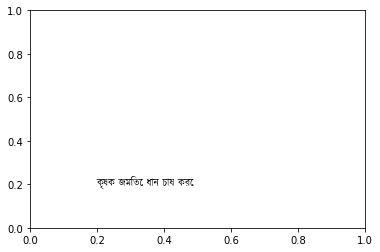

In [37]:
# for testing

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

prop = fm.FontProperties(fname='kalpurush.ttf')
s = "কৃষক জমিতে ধান চাষ করে"
x = 0.2
y = 0.2
plt.text(x, y, s, fontproperties=prop)
plt.show()

In [38]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

#banglar jonno kon font bhalo hoy oita thik korte hobe
seaborn.set(font=['kalpurush.ttf'], font_scale=3)

def attent_and_generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, katakana = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = seaborn.heatmap(attention_density[:len(katakana) + 2, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in katakana])

    ax.invert_yaxis()
    plt.show()


C:\Users\RANA_CSE\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['kalpurush.ttf'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


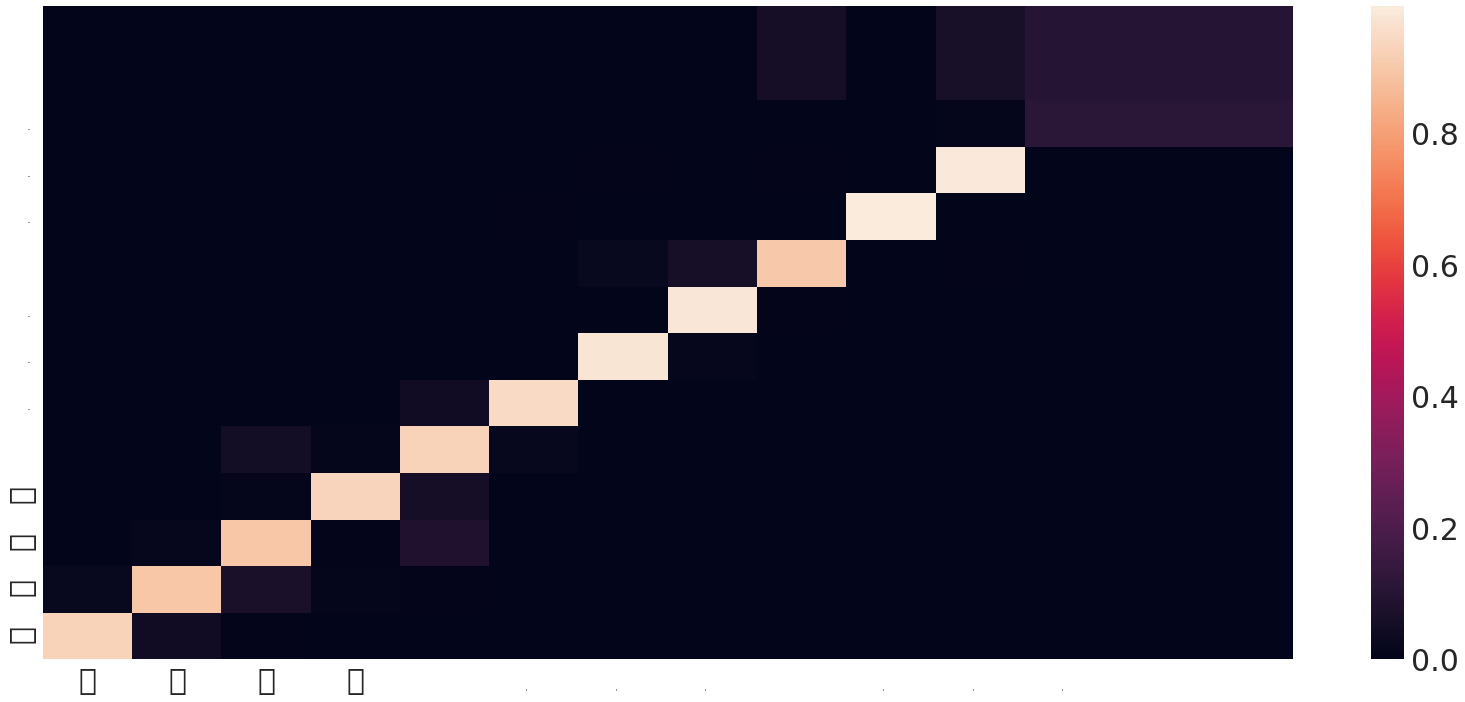

In [39]:
visualize('সাদা লাল নীল')

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


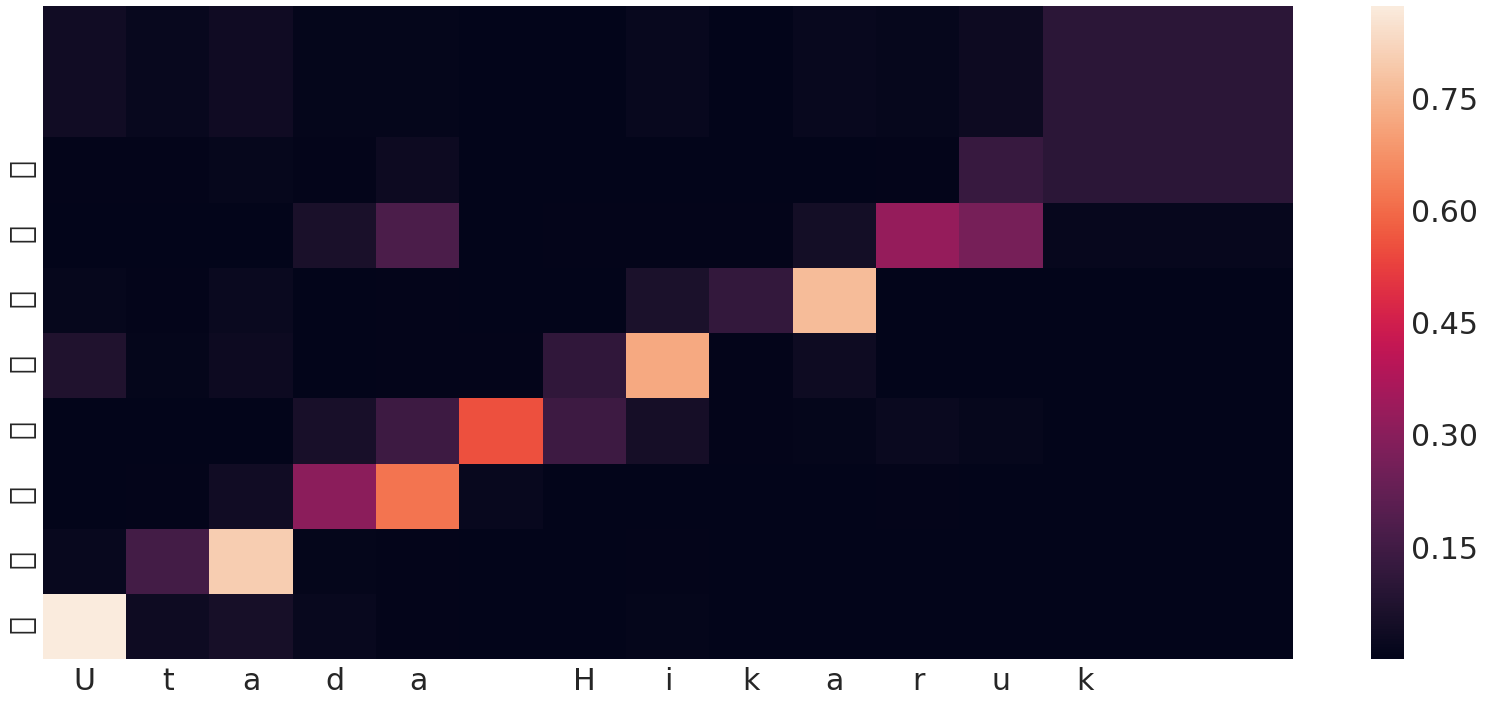

In [23]:
visualize('Utada Hikaruk')

In [11]:
visualize('Harry Potter')

NameError: name 'visualize' is not defined

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


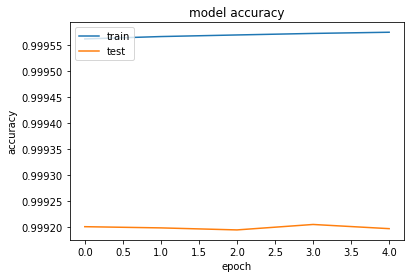

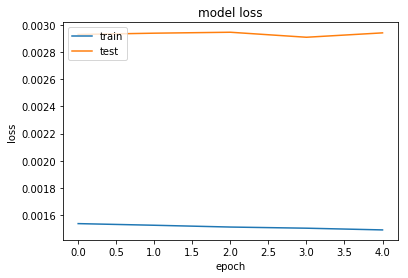

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()